In [1]:
import time
import numpy as np
from scipy import sparse
from scipy import linalg as la
from scipy.integrate import solve_ivp
from matplotlib import animation, pyplot as plt

from IPython.display import Video

In [2]:
π = np.pi
π2 = π**2
EMBED = False

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (10,2)
plt.rcParams["text.usetex"] = True

<h1 align="center">Model Reduction Example: Heat Equation</h1>
<h4 align="center">Shane McQuarrie</h4>

## Problem Setup

Consider the following initial/boundary value problem (IBVP) modeling diffusion of heat through a one-dimensional rod $\Omega = [0,1]$ with insulation at both ends:

$$
\begin{align*}
    x_t(t,\omega) &= \frac{1}{\pi^2}x_{\omega\omega}(t,\omega), & (t,\omega)&\in (0,T]\times\Omega,\\
    x_\omega(t,0) = x_\omega(t,1) &= 0, & t &> 0,\\
    x(0,\omega) = x_0(\omega) &= \cos(\pi \omega) + \varepsilon\cos(4\pi \omega) + 2, & \omega &\in\Omega.
\end{align*}
$$

The analytical solution to this equation is
$
x(t,\omega) = e^{-t}\cos(\pi \omega) + \varepsilon e^{-16t}\cos(4\pi \omega) + 2.
$

To solve the problem numerically, let $x_i:[0,T]\to\mathbb{R}$ denote the numerical approximation for $x(\cdot,\omega_i)$ for $i=1,\ldots,n$.
Discretizing the partial derivatives by second-order difference quotients (finite difference method) on a uniform grid, we arrive at the system

$$
\begin{align*}
    \dot{\mathbf{x}}(t) &= A\mathbf{x}(t),
    &
    \mathbf{x}(0) &= \mathbf{x}_0,
\end{align*}
$$

where $\mathbf{x}(t) = \begin{bmatrix}x_1(t) & \cdots & x_n(t)\end{bmatrix}^{\mathsf{T}}\in\mathbb{R}^n,\quad\mathbf{x}_0 = \begin{bmatrix}x_0(\omega_1) & \cdots & x_0(\omega_n)\end{bmatrix}^{\mathsf{T}}\in\mathbb{R}^n$, and

$$
A
= \frac{1}{\pi^2\Delta \omega^2}
\left[\begin{array}{ccccc}
-2 &      2 &        &        & 0  \\
 1 &     -2 &      1 &        &    \\
   & \ddots & \ddots & \ddots &    \\
   &        &      1 &     -2 &  1 \\
 0 &        &        &      2 & -2 \\
\end{array}\right] \in\mathbb{R}^{n\times n}.
$$

We can solve this with SciPy to get snapshots of the solution, from which we will construct the reduced order model.

In [3]:
n = 500                         # Number of spatial points in the discretization.
k = 200                         # Number of points in time stepping.
L = 1                           # Length of spatial domain.
T = 4                           # Final simulation time.

# Define the spatial and temporal domains and true solution.
w = np.linspace(0, 1, n)
t = np.linspace(0, T, k)
δw = w[1] - w[0]
δt = t[1] - t[0]

ε = 1
analytic_solution = lambda t, w: np.exp(-t)*np.cos(π*w) + ε*np.exp(-16*t)*np.cos(4*π*w) + 2

Xtrue = analytic_solution(t, w[:,np.newaxis])
x0 = analytic_solution(0, w)

In [4]:
# Construct the full-order model.
sub = np.concatenate((np.ones(n - 2), [2]))
A = sparse.diags([sub, -2, sub[::-1]],
                 offsets=[-1,0,1],
                 shape=(n,n)) / (δw**2 * π**2)

f = lambda t,x: A @ x

In [5]:
%%time
Xcomp = solve_ivp(f,                        # Solve dx / dt = Ax(t)
                  [0,T],                    # over t = [0,T]
                  x0,                       # with initial condition x0
                  t_eval=t,                 # evaluated at the specified times
                  method="BDF").y           # using an implicit scheme.

CPU times: user 243 ms, sys: 21.1 ms, total: 264 ms
Wall time: 104 ms


## Constructing the Reduced-order Model

Next, we take a sampling of the computed solution `Xcomp` to use as the snapshot data $X$.
This is an easy problem, so we can get away with taking only every $10$th time step (including the initial condition) over the first half of the time domain.

In [6]:
# Select snapshots from the computed trajectories: every 10th step for half of the time.
X = Xcomp[:,:Xcomp.shape[1]//2:10]
X.shape

(500, 10)

Before computing a POD basis of the snapshot matrix $X$, we must choose $r$, the number of basis vectors to use.
The singular values inform this decision.

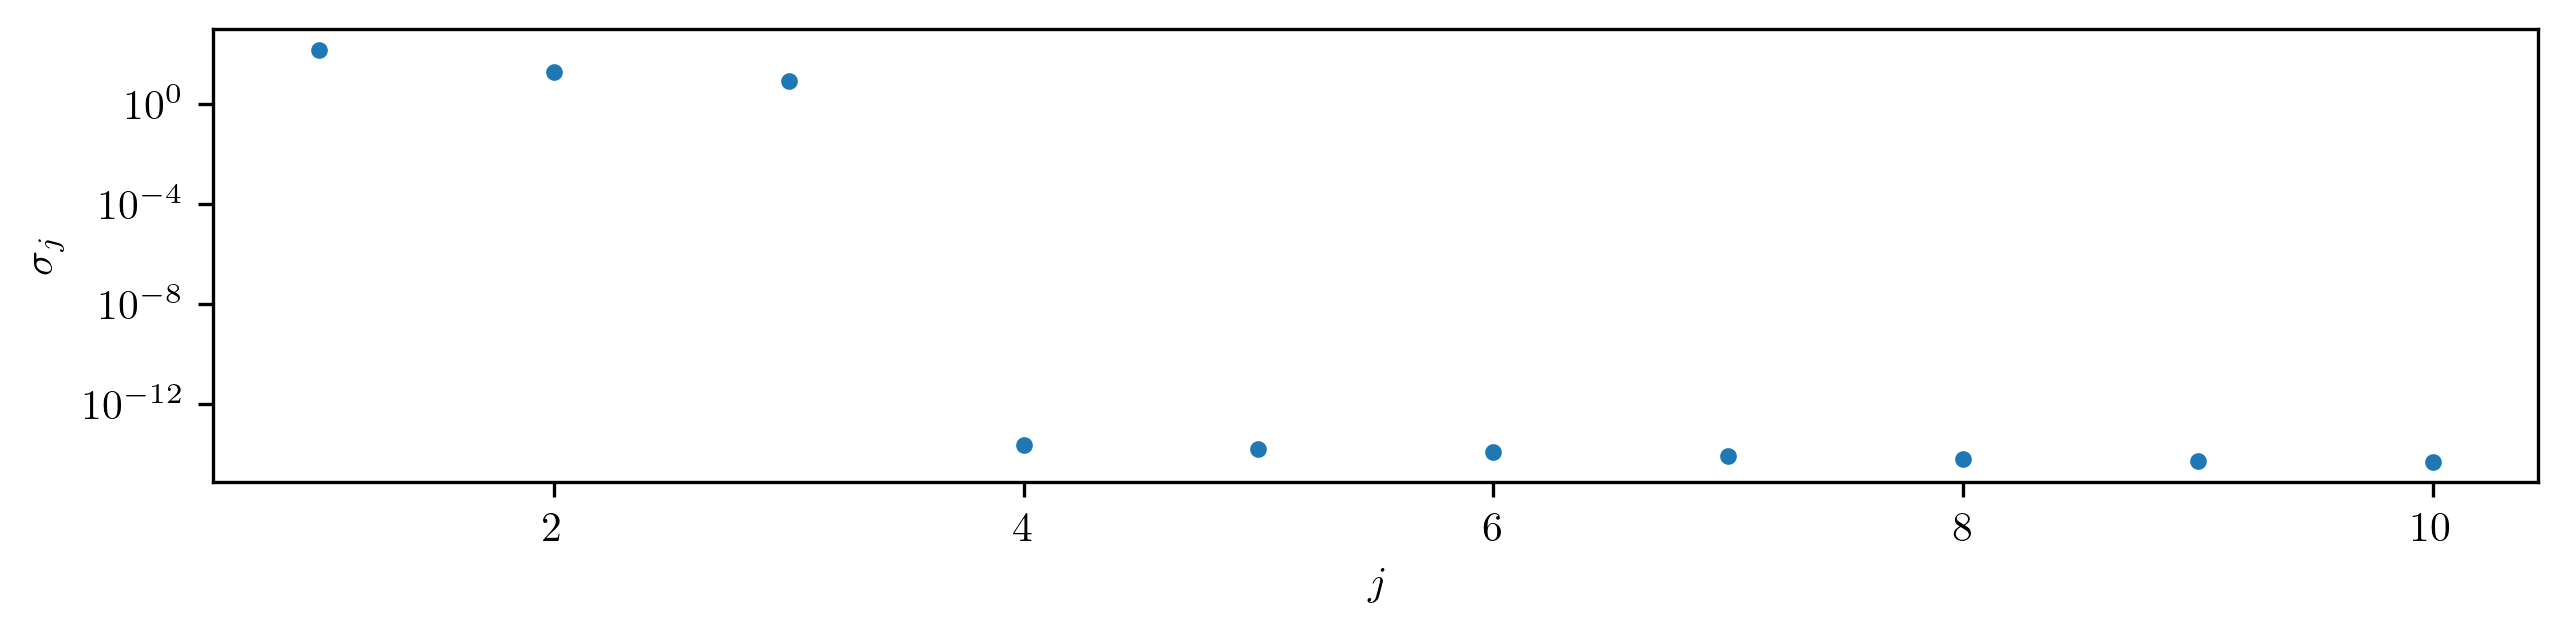

In [7]:
snapshot_svdvals = la.svdvals(X)
plt.semilogy(np.arange(1,X.shape[1]+1), snapshot_svdvals, '.')
plt.xlabel(r"$j$")
plt.ylabel(r"$\sigma_{j}$")
plt.show()

For this example, it is clear that $r = 3$ components capture most of the information.
We therefore compute the POD basis of order $3$, which consists of the first $3$ left singular vectors of $X$.

In [8]:
def POD_basis(X, r):
    """Compute the POD basis of order r corresponding to the data in X.
    
    Parameters
    ----------
    X : (n,k) ndarray
        Snapshot matrix, usually with n >> k.
        
    r : int
        Number of POD basis vectors to compute.
    
    Returns
    -------
    Vr : (n,r) ndarray
        The first r POD basis vectors of X.
    """
    Phi = la.svd(X, full_matrices=False)[0]
    return Phi[:,:r]

In [9]:
# Compute the POD basis of rank r corresponding to the snapshots.
r = 3
Vr = POD_basis(X, r)
Vr.shape

(500, 3)

To see if we're on the right track, we visualize each of the selected POD basis vectors, which live in the same space as the snapshots $\left(\mathbb{R}^n\right)$.
Note that the first three vectors capture the characteristics of the solution fairly well.

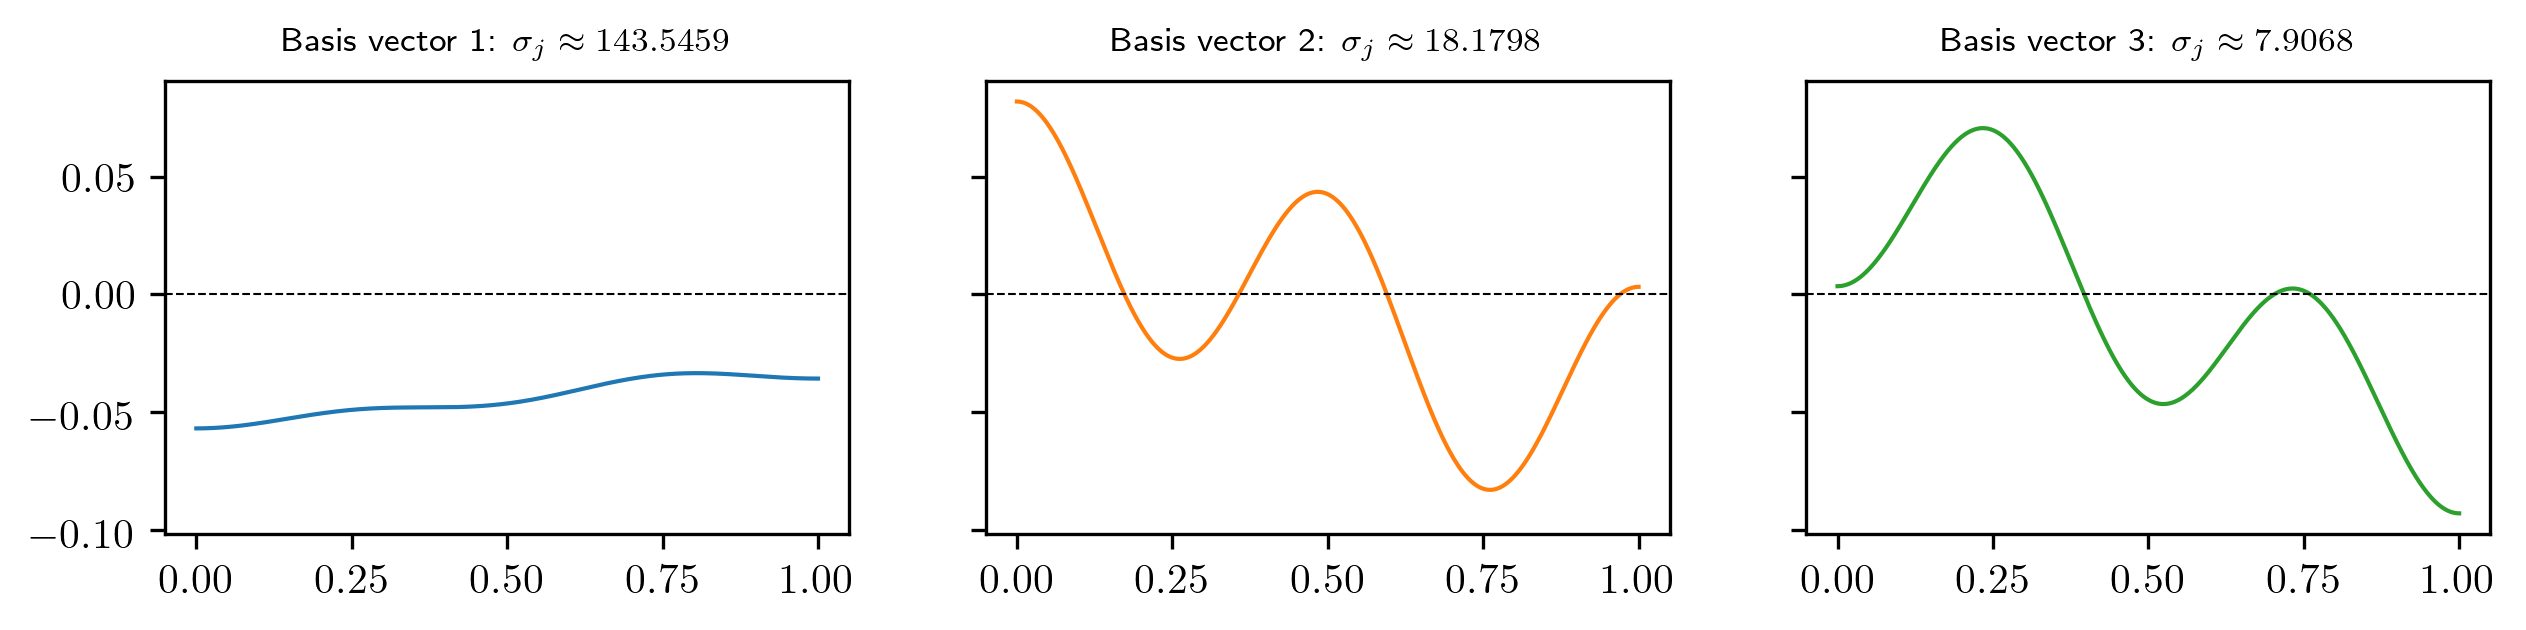

In [10]:
rows = (r//3) + 1 if not r//3 else r//3
fig, axes = plt.subplots(rows, 3, sharex=True, sharey=True, figsize=(10,2*rows))
for j,ax in zip(range(r), axes.flatten()):
    ax.plot(w, Vr[:,j], f"C{j}", lw=1)
    ax.axhline(0, c='k', ls='--', lw=.5)
    ax.set_title(fr"Basis vector {j+1}: $\sigma_j\approx {snapshot_svdvals[j]:.4f}$", fontsize=8)
plt.show()

Now that we have $V_r$, we project the linear operator $A$ to the reduced operator $\hat{A} = V_r^\mathsf{T} A V_r$ and compute the reduced initial condition $\hat{\mathbf{x}}_0 = V_r^\mathsf{T}\mathbf{x}_0$.
This projection is called the _offline phase_, since it can be done a priori.

In [11]:
%%time
# Offline phase: construct the reduced-order model.
x0_ = Vr.T @ x0              # Initial condition
A_ = Vr.T @ A @ Vr           # State matrix

f_ = lambda t,x_: A_ @ x_

print("Original system size:", A.shape)
print("Reduced system size:", A_.shape)

Original system size: (500, 500)
Reduced system size: (3, 3)
CPU times: user 1.61 ms, sys: 1.82 ms, total: 3.43 ms
Wall time: 4.06 ms


The _online phase_ is the actual simulation of the $r$-dimensional ROM.
Note that it is (obviously) much faster than the high-dimensional simulation.

In [12]:
%%time
# Online phase: solve the reduced system.
X_rom_ = solve_ivp(f_,
                  [0,4],
                  x0_,
                  t_eval=t,
                  method="BDF").y

CPU times: user 13.6 ms, sys: 1.4 ms, total: 15 ms
Wall time: 13.9 ms


Finally, project the reduced solution in $\mathbb{R}^r$ back to the original space $\mathbb{R}^n$ as $\mathbf{x}_\text{ROM} = V_r \hat{\mathbf{x}}$.

In [13]:
# Project the solution back up to the original space.
X_ROM = Vr @ X_rom_
assert Xcomp.shape == X_ROM.shape

## Results and Error Analysis

We'll do three things to visualize the results:
- Plot a few snapshots and the corresponding ROM outputs
- Compute relative error measures between the snapshots and the ROM outputs
- Animate both the snapshot set and the ROM outputs

In [14]:
def plot_heat_data(Z, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12,4))

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 10, 20, 40, 80, 160]
    color = iter(plt.cm.viridis_r(np.linspace(0, .8, len(sample_columns))))
    for j in sample_columns:
        ax.plot(w, Z[:,j], color=next(color), label=rf"$x(\omega,t_{{{j}}})$")
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$x(\omega,t)$")
    ax.legend(loc="upper right")
    ax.set_title(title)

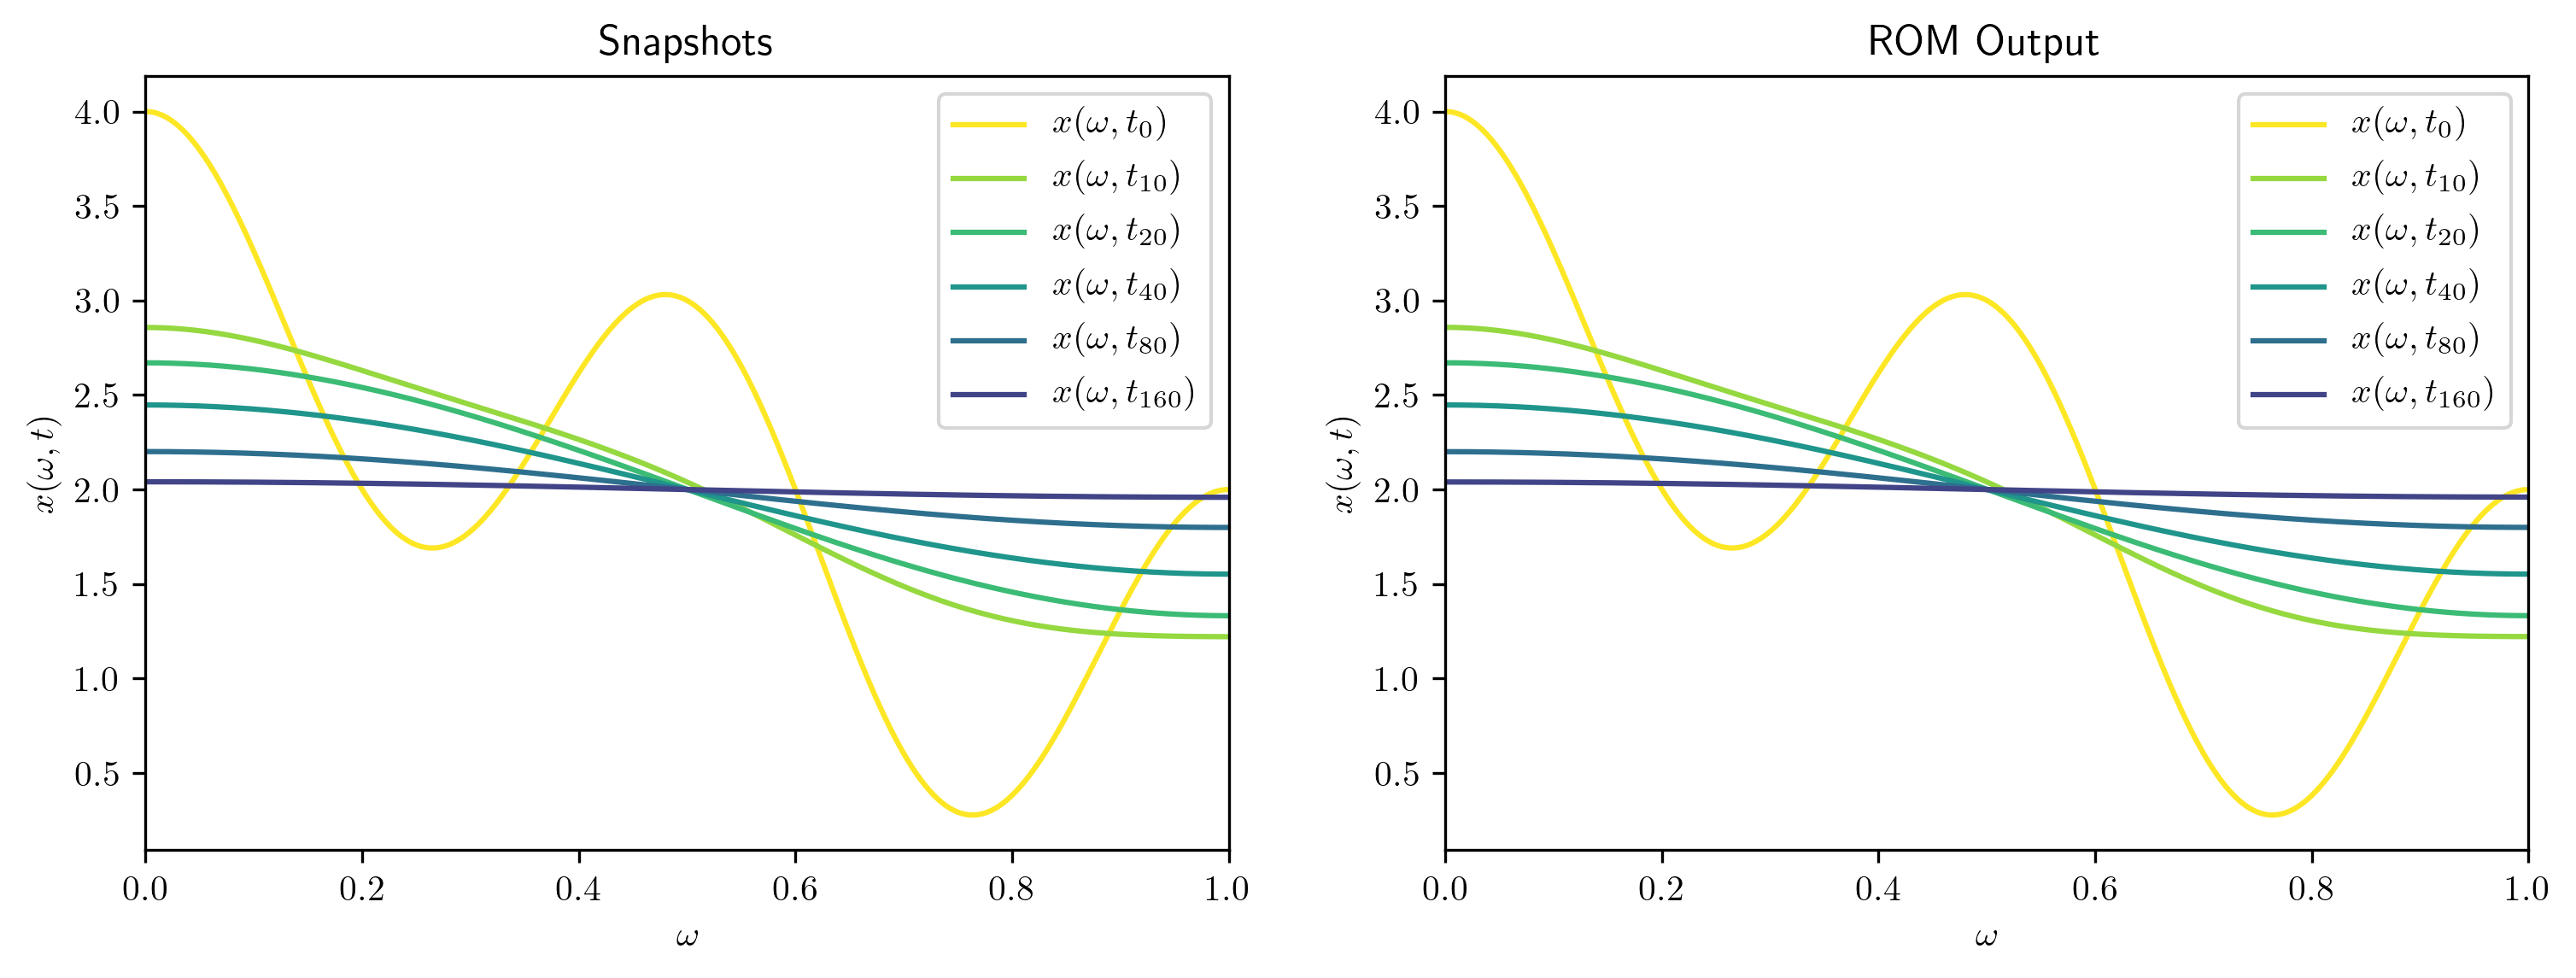

In [15]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,4))
plot_heat_data(Xcomp, "Snapshots", ax1)
plot_heat_data(X_ROM, "ROM Output", ax2)

The relative $L^2$ error of the reduced order approximation $\mathbf{x}_\text{ROM}$ is given by

$$
\text{Err} %_\text{rel}
= \frac{\|\mathbf{x}(\cdot) - \mathbf{x}_\text{ROM}(\cdot)\|_{L^2([0,T])}}{\|\mathbf{x}(\cdot)\|_{L^2([0,T])}}.
$$

We approximate the $L^2([0,T])$ norms by numerical integration, for example with the Trapezoidal Rule:

$$
\begin{align}
    \|\mathbf{x}(\cdot)\|_{L^2([0,T])}^2
    &= \int_0^1 \|\mathbf{x}(t)\|_2^2\:dt\\
    &\approx \delta t\left(\frac{1}{2}\|\mathbf{x}(t_0)\|_2^2 + \sum_{j=1}^{k-1}\|\mathbf{x}(t_j)\|_2^2 + \frac{1}{2}\|\mathbf{x}(t_k)\|_2^2\right).
\end{align}
$$

In [16]:
def relative_L2_error(x, y, t):
    """Compute the relative L2-norm error between x and y.
    
    Parameters
    ----------
        x : (n,k) ndarray
            True data.
            
        y : (n,k) ndarray
            Approximation to x.
            
        t : (k,) ndarray
            Time domain of data.
    """
    numerator = np.sqrt(np.trapz(np.sum((x - y)**2, axis=0), t))
    denominator = np.sqrt(np.trapz(np.sum(x**2, axis=0), t))
    return numerator / denominator

err = relative_L2_error(Xcomp, X_ROM, t)
print(f"Relative Error: {err*100:.6f}%")

Relative Error: 0.026120%


Finally, we animate the solutions in the same plot and look for differences.

In [17]:
def animate_1D_funcs(save_as, w, t, state_list, labels=None):
    """Animate one or more one-dimensional functions on R over a time domain.
    
    Parameters
    ----------
    save_as : str
        File to save the video as (e.g. "heat.mp4").
    
    w : (n,) ndarray
        Spatial domain of the function(s).
    
    t : (K,) ndarray
        Time domain of the function(s).
    
    state_list : list((n,K) ndarray)
        Computed function values. Each column gives the solution over the domain w at a given time.
    
    labels : list(str)
        Labels corresponding to the state list.
    """
    s = len(state_list)
    if labels is None:
        labels = [str(i) for i in range(s)]

    x0 = state_list[0][:,0]
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    lines = [ax.plot(w, x0, '-', lw=1, label=labels[i])[0] for i in range(s)]
    ax.axis([0, 1, min(X.min() for X in state_list),
                   max(X.max() for X in state_list)])
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$x(t,\omega)$")
    ax.legend(loc="lower left")

    def update_animation(index):
        for i in range(s):
            lines[i].set_ydata(state_list[i][:,index])

    dt = np.mean(np.diff(t))
    writer = animation.writers["ffmpeg"](fps=int(1/dt))
    with writer.saving(fig, save_as, 200):
        for index in range(len(t)):
            update_animation(index)
            writer.grab_frame()
    plt.close()

In [18]:
video_name = "heat_linear_r=3.mp4"
animate_1D_funcs(video_name, w, t, [Xcomp, X_ROM], ["Snapshots", "ROM Output"])
Video(video_name, width=1200, height=500, embed=EMBED)

In this experiment, the training data and the ROM output are visibly identical.

## The Choice of Reduced Dimension Matters

With only $r = 3$ modes, we are able to accurately simulate this heat equation with high accuracy.
This is reasonable because the singular values of the snapshot matrix $X$ are essentially zero except for the first $3$.
In fact, we shouldn't expect much improvement at all after including the first 4 or 5 singular values.
On the other hand, using $r = 2$, we see some visible discrepancy between the ROM and the snapshot set.

In [19]:
def linear_ROM(A, t, X, r, x0=None, method="BDF"):
    """Set up and solve the low-dimensional linear IVP
    
        dx_ / dt = A_ x_,   x_(t0) = x0_
    
    corresponding to the high-dimensional linear IVP
    
        dx / dt = A x,      x(t0) = x0.
    
    Parameters
    ----------
        A : (n,n) ndarray
            Linear evolution operator for the original, high-dimensional system.
        
        t : (K,) ndarray
            Times at which to evaluate the solution.
        
        X : (n,k) ndarray
            Snapshot matrix of sample solutions.
        
        r : int
            Dimension of desired reduced system.
        
        x0 : (n,) ndarrray
            High-dimensional initial condition. If not provided, use the first snapshot.
        
        method : str
            `method` keyword for scipy.integrate.solve_ivp().
        
    Returns
    -------
        X_ROM : (n,K) ndarray
            Approximate solution to the original, high-dimensional IVP.
    """
    if x0 is None:
        x0 = X[:,0]
    
    # Offline phase
    Vr = POD_basis(X, r)
    x0_ = Vr.T  @ x0
    A_ = Vr.T @ A @ Vr
    
    # Online phase
    X_ = solve_ivp(lambda t,x_: A_ @ x_,
                   (t[0], t[-1]),
                   x0_,
                   t_eval=t,
                   method=method).y
    
    return Vr @ X_

In [20]:
X_rom2 = linear_ROM(A, t, X, 2, x0)
err = relative_L2_error(Xcomp, X_rom2, t)
print(f"Relative Error: {err*100:.6f}%")

video_name = "heat_linear_r=2.mp4"
animate_1D_funcs(video_name, w, t, [Xcomp, X_rom2], ["Snapshots", "ROM"])
Video(video_name, width=1200, height=500, embed=EMBED)

Relative Error: 9.188259%


To see better how reduced dimension $r$ affects accuracy, we compute the relative errors for the ROM with $r=1,2,\ldots,12$.

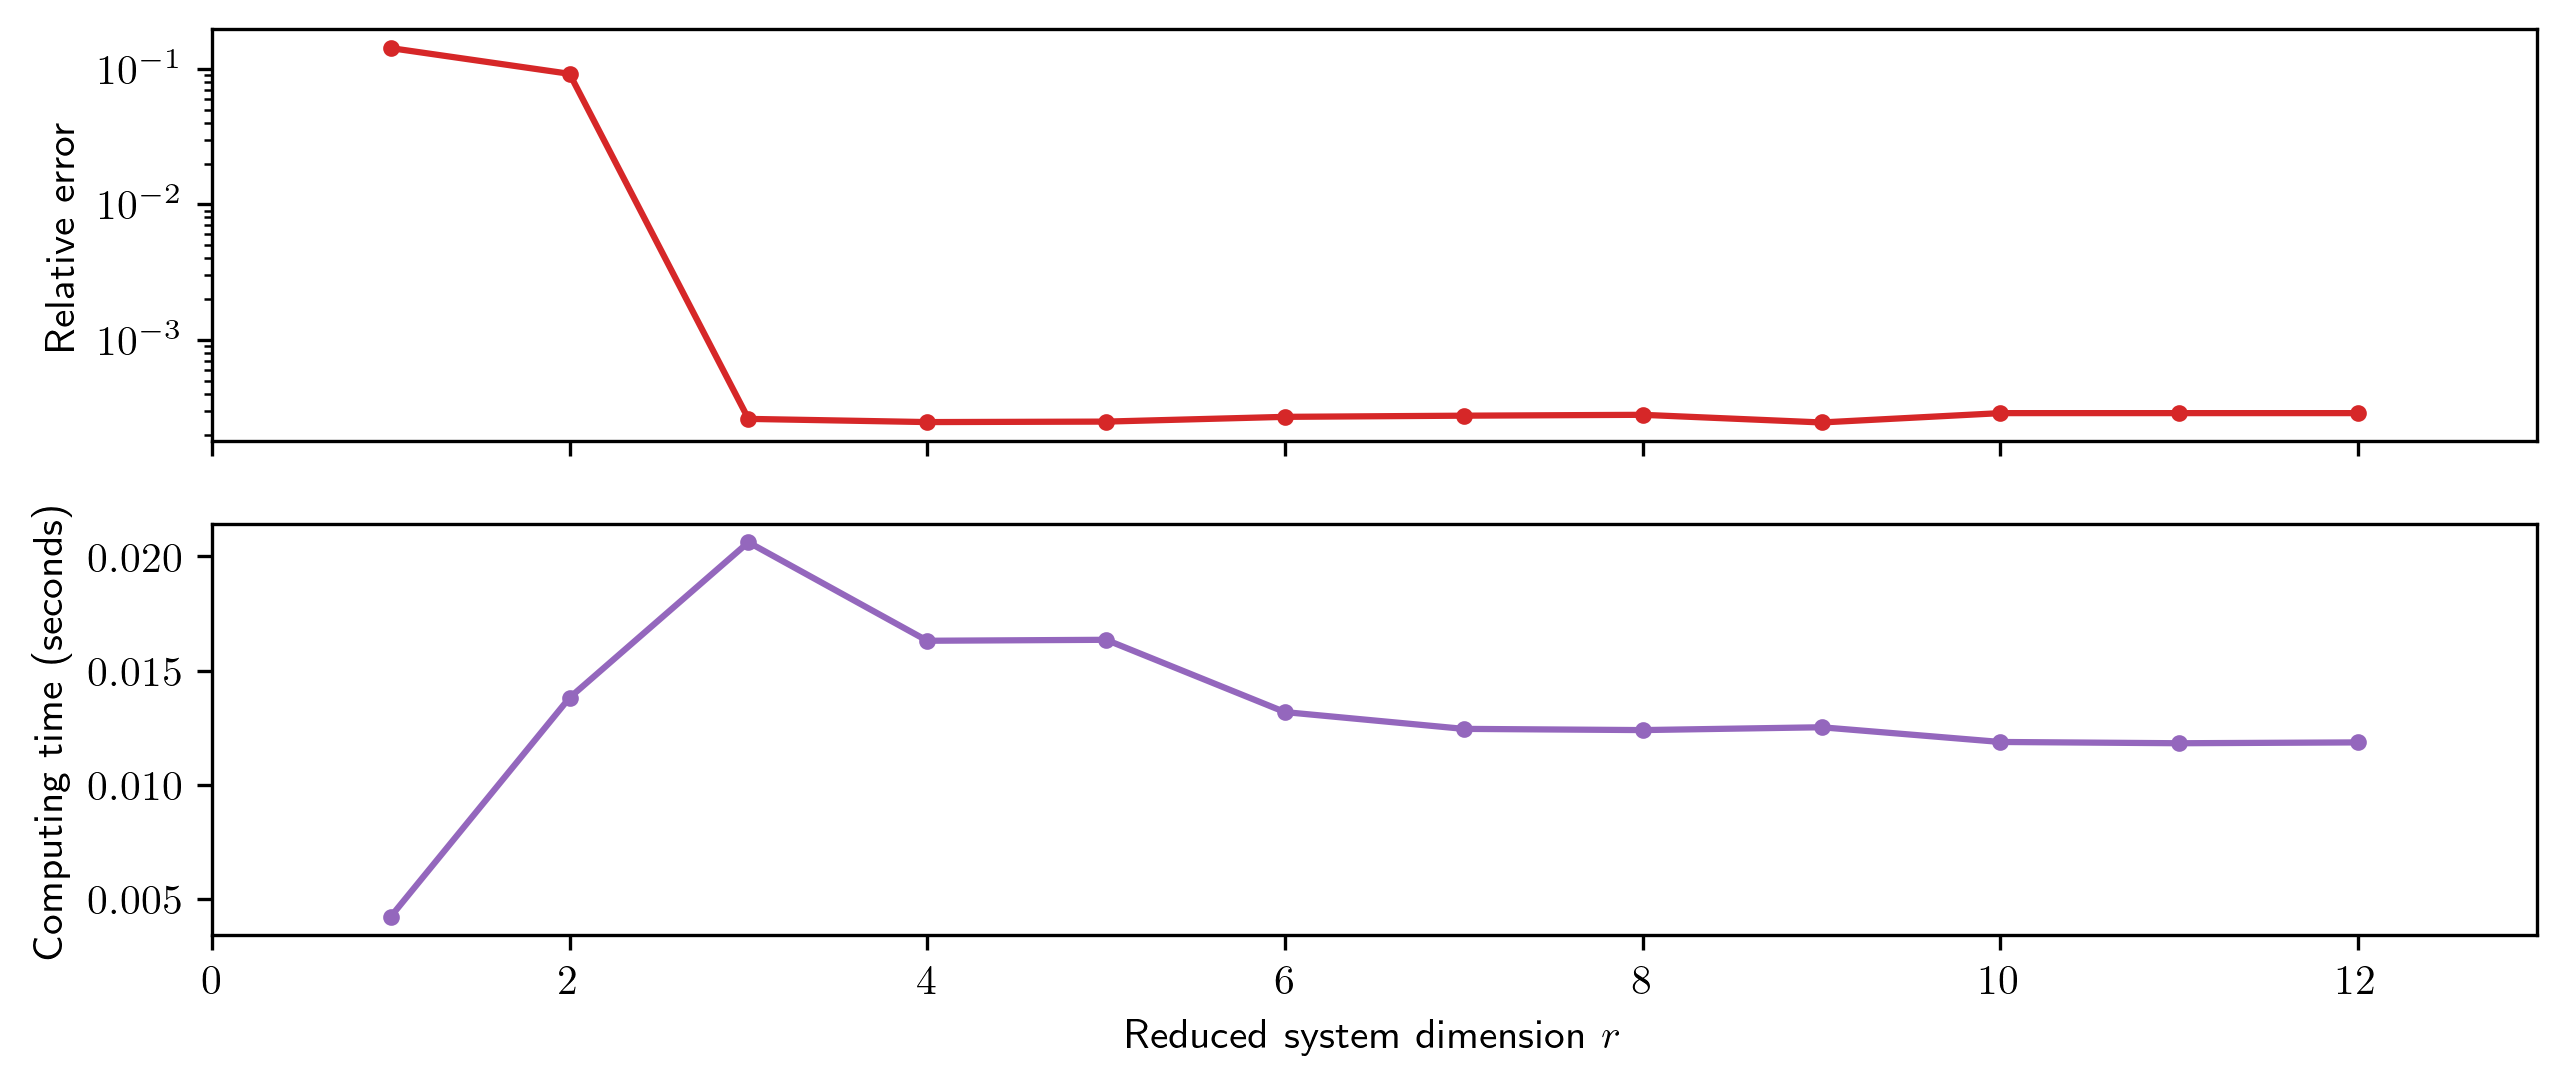

In [21]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(10,4))

errors, times = [], []
rs = np.arange(12) + 1
for r in rs:
    start_time = time.time()
    X_rom_r = linear_ROM(A, t, X, r, x0)
    times.append(time.time() - start_time)
    errors.append(relative_L2_error(Xcomp, X_rom_r, t))
ax1.semilogy(rs, errors, 'C3.-')
ax2.plot(rs, times, 'C4.-')

ax1.set_ylabel("Relative error")
ax2.set_xlabel(r"Reduced system dimension $r$")
ax2.set_ylabel("Computing time (seconds)")
ax2.set_xlim(0, rs.max()+1)
plt.show()